# Classification. Linear models and KNN

## ЛУЧШЕ СМОТРЕТЬ ЗДЕСЬ => https://nbviewer.org/github/DmitryShuvalov/ml_intro_5-Classification-Linear-KNN/blob/main/hw_classification.ipynb

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [11]:
import math
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
 import math
       
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.losshist = list()
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        sigm = [1/(1 + math.exp(- weights.T @ x))
                for x in X
               ]
        return sigm
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        return np.mean([math.log(1 + math.exp(- (weights @ x[i,:]) * y[i]))
                for i in range(0, x.shape[0])]) + 1/(2*self.C)*(np.linalg.norm(weights)**2)
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        losshist = list()    
        weight0 = self.weights_
        for i in range(self.max_iter):
            delta = np.mean([y[j] * X_ext[j,:] * (1-1/(1+np.exp(-y[j] * (self.weights_ @ X_ext[j,:]))))
                             for j in range(0, X_ext.shape[0])
                            ], axis=0) - 1/self.C * self.weights_
            
            self.weights_ += self.eta * delta
            
            self.losshist.append(self.get_loss(x=X_ext, weights= self.weights_, y=y))
            
            if np.linalg.norm(self.eta * delta) < self.tol:
                break
                
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return -1 + 2 * np.round(np.array(self.get_sigmoid(X_ext, self.weights_)))
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
        
        

In [12]:
from sklearn import datasets
from sklearn import metrics

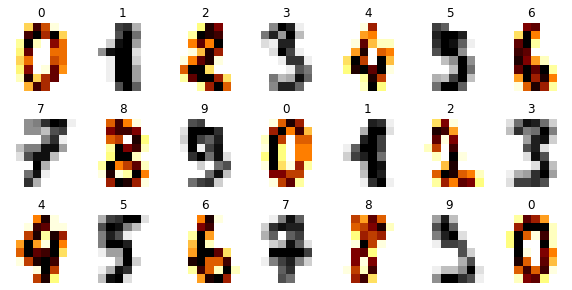

In [13]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [14]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [15]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test, plot_conf_matrix = True):
    clf.fit(X_train, y_train)
    if plot_conf_matrix:
        disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
        disp.figure_.suptitle("Confusion Matrix")
        plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [16]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [17]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [18]:
lr_clf.fit(X_train, y_train)

In [19]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [20]:
model = CustomLogisticRegression()

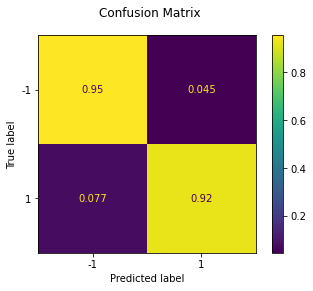

In [21]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [22]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [23]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

1000


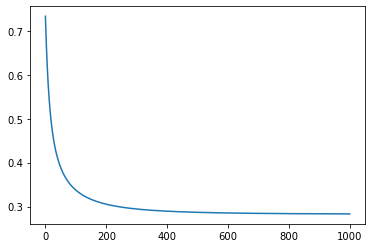

In [24]:
## your code
print(len(model.losshist))
plt.plot(model.losshist)

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

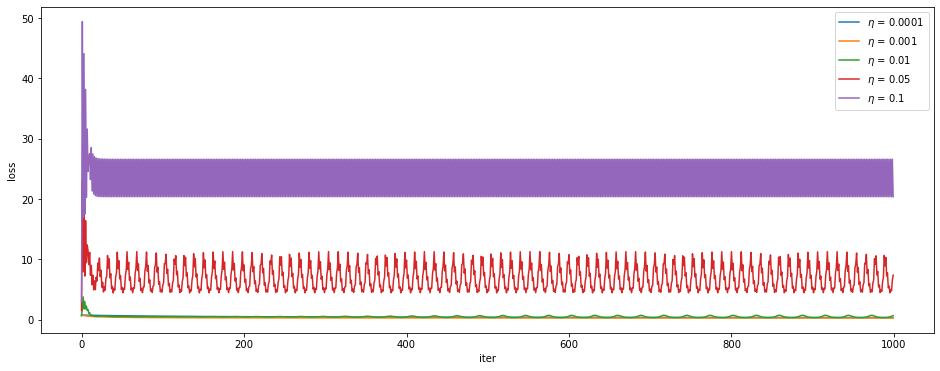

In [25]:
## your code
plt.figure(figsize=(16,6))
for η in [0.0001, 0.001, 0.01, 0.05, 0.1]:
    model = CustomLogisticRegression(eta = η)
    model.fit(X_train, y_train)
    #train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    plt.plot(model.losshist, label = f'$η$ = {η} ')


plt.xlabel("iter")
plt.ylabel("loss")
plt.legend()
plt.show()

##### <font color="red"> Мои мысли </font>
Абсолютно видно, что при увеличении *learning rate* $\eta$ ухудшется сходимость нашей последовательности и конечный результат будет зависить от последней итерации. Это и логично, так как параметром $\eta$ мы изменяем величину "прибавочного" вектора $\eta \frac{1}{C} w$.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

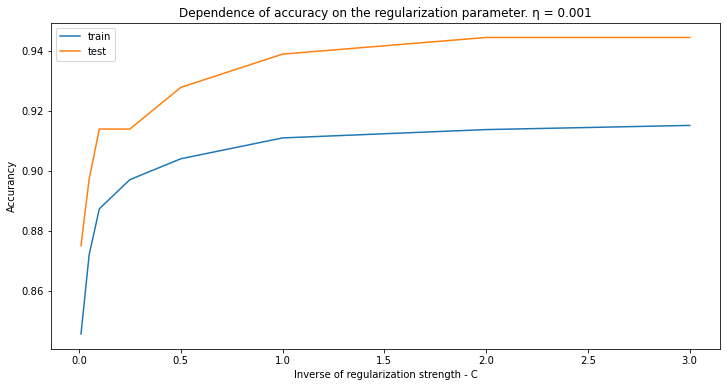

In [26]:
## your code
train_acc_arr = list()
test_acc_arr = list()
C = [0.01, 0.05, 0.1, 0.25, 0.5, 1, 2, 3]
for c in C:
    model=CustomLogisticRegression(C=c)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test, plot_conf_matrix=False)
    train_acc_arr.append(train_acc)
    test_acc_arr.append(test_acc)
plt.figure(figsize=(12,6))
plt.plot(C, train_acc_arr, label="train")
plt.plot(C, test_acc_arr, label='test')
plt.xlabel('Inverse of regularization strength - C')
plt.ylabel("Accurancy")
plt.title("Dependence of accuracy on the regularization parameter. η = 0.001")
plt.legend()
plt.show()

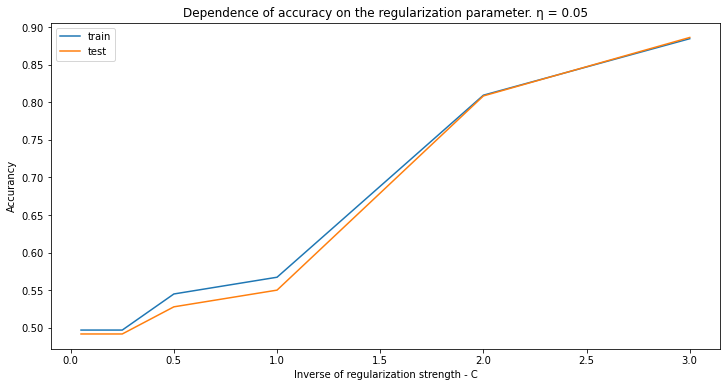

In [27]:
train_acc_arr = list()
test_acc_arr = list()
C = [0.05, 0.1, 0.25, 0.5, 1, 2, 3]
for c in C:
    model=CustomLogisticRegression(eta=0.05, C=c)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test, plot_conf_matrix=False)
    train_acc_arr.append(train_acc)
    test_acc_arr.append(test_acc)
plt.figure(figsize=(12,6))
plt.plot(C, train_acc_arr, label="train")
plt.plot(C, test_acc_arr, label='test')
plt.xlabel('Inverse of regularization strength - C')
plt.ylabel("Accurancy")
plt.title("Dependence of accuracy on the regularization parameter. η = 0.05")
plt.legend()
plt.show()

##### <font color="red"> Мои мысли </font>
Абсолютно видно, что при увеличении параметра силы регуляризации $С$ точность модели возрастает даже при большом параметре $\eta$. Это и логично, так как увеличением параметра $С$ мы уменьшаем величину "прибавочного" вектора $\eta \frac{1}{C} w$.

**(0.5 points)** Compare zero initialization and random initialization. 

In [28]:
## your code
modelNonZeroInit = CustomLogisticRegression(zero_init=True)
modelZeroInit = CustomLogisticRegression(zero_init=False)

modelNonZeroInit.fit(X_train, y_train)
modelZeroInit.fit(X_train, y_train)

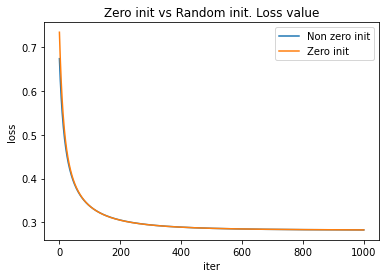

In [29]:
plt.plot(modelNonZeroInit.losshist, label="Non zero init")
plt.plot(modelZeroInit.losshist, label="Zero init")
plt.title("Zero init vs Random init. Loss value")
plt.ylabel("loss")
plt.xlabel("iter")
plt.legend()
plt.show()

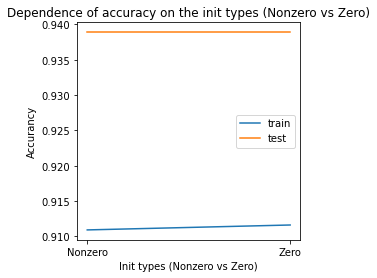

In [30]:
train_acc_arr = list()
test_acc_arr = list()
init_types = [False, True]
init_types_str=['Nonzero','Zero']

for init_type in init_types:
    model=CustomLogisticRegression(zero_init=init_type)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test, plot_conf_matrix=False)
    train_acc_arr.append(train_acc)
    test_acc_arr.append(test_acc)
    
plt.figure(figsize=(4,4))
plt.plot(init_types_str, train_acc_arr, label="train")
plt.plot(init_types_str, test_acc_arr, label='test')
plt.xlabel('Init types (Nonzero vs Zero)')
plt.ylabel("Accurancy")
plt.title("Dependence of accuracy on the init types (Nonzero vs Zero)")
plt.legend()
plt.show()

##### <font color="red"> Мои мысли </font>
Очевидно, что нет большой разницы какой вектор выбирать в качестве начального вектора весов. В любом случае аппроксимация выйдет на тот же результат. Есть незначительная разница на датасете x_train, но это скорее всего просто погрешность.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [31]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        return np.array([[np.linalg.norm(x-y)
                for y in Y]
                for x in X])
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        df = pd.DataFrame(data= {'class': y, 'weight': weights })
        df = df.sort_values(by="weight", ascending=False).head(self.n_neighbors).groupby('class')['weight'].sum()
        for cl in self.classes_:
            if not(cl in df.index.values):
                df.loc[cl] = 0 
      
        return df[self.classes_]
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1/(P + self.eps) #'your code
                
            # <your code>
            ttt = np.array([ self.get_class_weights(self.y, w)
                          for w in weights_of_points
                        ])

            res = np.array([p/p.sum()
                            for p in ttt
                           ])
            return np.array(res)
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        P = self.predict_proba(X)
        return np.argmax(P, axis=1)

In [32]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [33]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [34]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

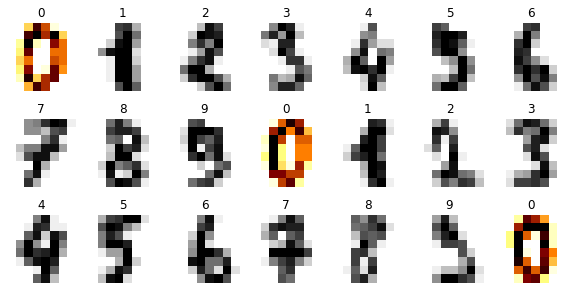

In [35]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 20 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [36]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [37]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

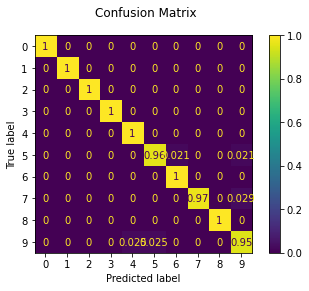

In [38]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [39]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

##### <font color="red"> Мои мысли </font>
Встречаются ошибки определения цифр 5, 7, 9. При этом цифра 5 иногда определяется как 6 или 9, цифра 7 - как 9, цифра 9 как 4 или 5. Ошибка происходит из-за схожести написания и неаккуратности пишущего. Очень странно, что нет ошибок с цифрой 1 и 8. 

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

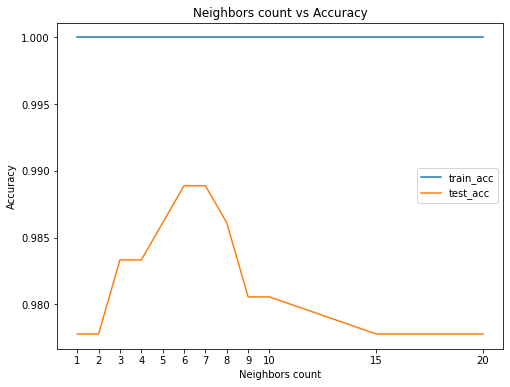

Wall time: 902 ms


In [40]:
%%time
## your code
plt.figure(figsize=(8,6))
train_acc_arr=list()
test_acc_arr=list()
n_neighbors_list = [1,2,3,4,5,6,7,8,9,10,15,20]
for n_neighb in n_neighbors_list:
    model = KNeighborsClassifier(n_neighbors=n_neighb, weights='distance')#CustomKNeighborsClassifier(n_neighbors=n_neighb, weights='distance')
    model.fit(X_train, y_train)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test, plot_conf_matrix=False)
    train_acc_arr.append(train_acc)
    test_acc_arr.append(test_acc)
    

plt.plot(n_neighbors_list, train_acc_arr, label = f'train_acc')
plt.plot(n_neighbors_list, test_acc_arr, label = f'test_acc')

plt.title('Neighbors count vs Accuracy')
plt.xticks(n_neighbors_list)
plt.xlabel("Neighbors count")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##### <font color="red"> Мои мысли </font>
Увеличение количества соседей (параметра *n_neibhors*) начиная с 1 до некоторого числа увеличивает качество модели, но дальнейшее увеличение ухудшает качество, что предсказуемо, так как увеличивается область, а соответсвенно и увеличивается вероятность того, что "приграничные" сэмплы будут отнесены к неправильной группе из-за возможной разной "концентрации" тренировочных сэмплов. Для train датасета разницы нет.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [41]:
%%time
## your code

dist_acc_arr=list()
unif_acc_arr=list()
n_neighbors_list = [1,3,5,7,9,11,15]
for n_neighb in n_neighbors_list:
    model = KNeighborsClassifier(n_neighbors=n_neighb, weights='distance') #  CustomKNeighborsClassifier(n_neighbors=n_neighb, weights='distance')
    model.fit(X_train, y_train)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test, plot_conf_matrix=False)
    dist_acc_arr.append(test_acc)

    model = KNeighborsClassifier(n_neighbors=n_neighb) #CustomKNeighborsClassifier(n_neighbors=n_neighb, weights='uniform')
    model.fit(X_train, y_train)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test, plot_conf_matrix=False)
    unif_acc_arr.append(test_acc)
    

Wall time: 1.24 s


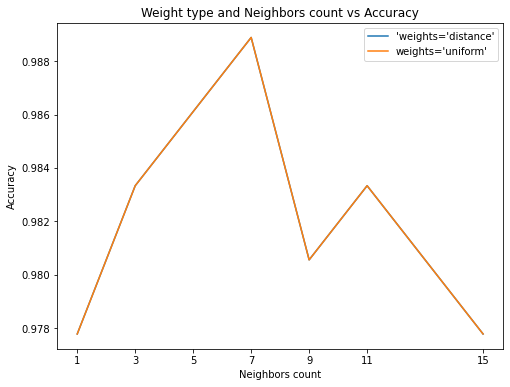

In [42]:
plt.figure(figsize=(8,6))
plt.plot(n_neighbors_list, dist_acc_arr, label = f"'weights='distance'")
plt.plot(n_neighbors_list, unif_acc_arr, label = f"weights='uniform'")

plt.title('Weight type and Neighbors count vs Accuracy')
plt.xticks(n_neighbors_list)
plt.xlabel("Neighbors count")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##### <font color="red"> Мои мысли </font>
Использование *uniform* или *distance* не даёт никакой разницы. Как минимум, при использовании KNeighborsClassifier

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

##### <font color="red"> Мои мысли </font>
* Если для задачи распознавания, то можно предварительно преобразовать в 0 и 1 (по некоторому пороговому значению), затем по коэффициенту подобия (сколько 1 совпадает в исследуемом образце и в обущающих образцах). Где больше совпадение - там больше вероятность. Плюсы - возможно лучшая устойчивость к фону и неяркому мусору.

Метрики не для этой задачи:
* Можно использовать не просто эвклидово расстояние между сэмплами, а эвклидово расстояние, умноженное на вес каждого класса. Так можно делать класс более или менее значимым. 
* А можно для яблок использовать следующую метрику: если зелёное - то вес, если красное - то диаметр, а если жёлтое - то запах по шкале. Всё зависит от задач

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

##### <font color="red"> Мои мысли </font>
Для вышеуказанной метрики
* Например, распознавание образов на картинке. 
* Исследование звёздного неба


## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [43]:
PATH = "./data/"


In [44]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [45]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

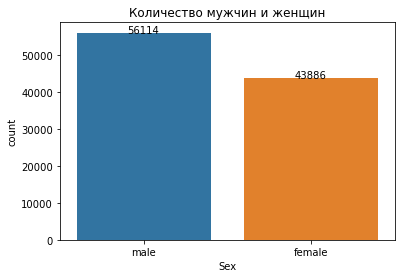

In [46]:
#Количество записей с NaN Sex равно нулю, поэтому можно не обнулять

ax = sns.countplot(data=data, x='Sex')

for p in ax.patches:
   ax.annotate(p.get_height(), (p.get_x()+0.3, p.get_height()))

plt.title('Количество мужчин и женщин')
plt.show()

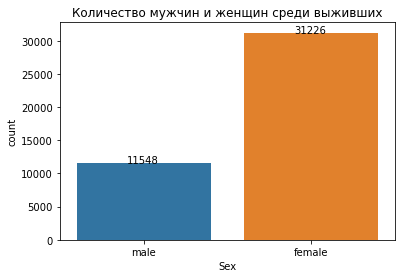

In [47]:
ax = sns.countplot(data = data[data['Survived'] == 1], x='Sex')

for p in ax.patches:
   ax.annotate(p.get_height(), (p.get_x()+0.3, p.get_height()))

plt.title('Количество мужчин и женщин среди выживших')
plt.show()

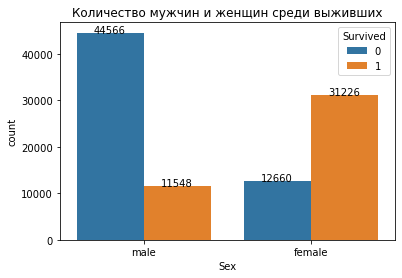

In [48]:
ax = sns.countplot(data = data, x='Sex', hue='Survived')

for p in ax.patches:
   ax.annotate(p.get_height(), (p.get_x()+0.1, p.get_height()))

plt.title('Количество мужчин и женщин среди выживших')
plt.show()

##### <font color="red"> Мои мысли </font>
Очевидно, что несмотря на физическое и численное превосходство, мужчины уступали места в спасательных лодка женщинам, поэтому количество выживших женщин почти в три раза больше количества выживших мужчин

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [49]:
print(data[data['Survived'].isna()].shape[0])

0


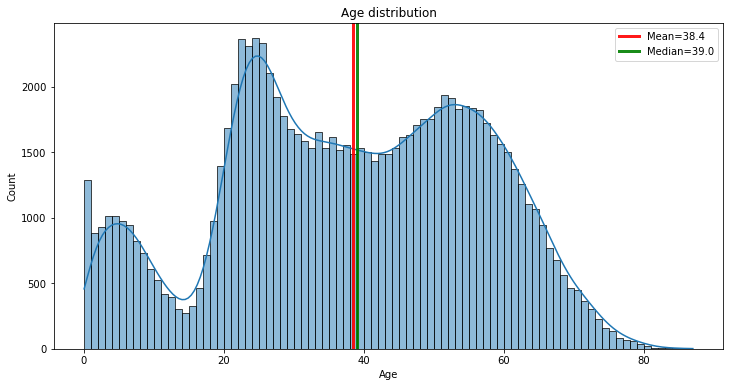

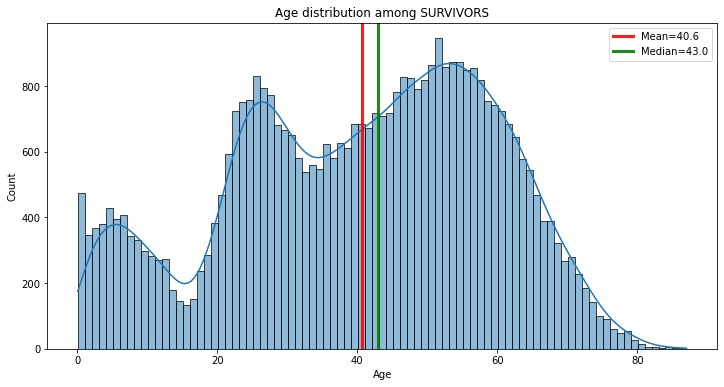

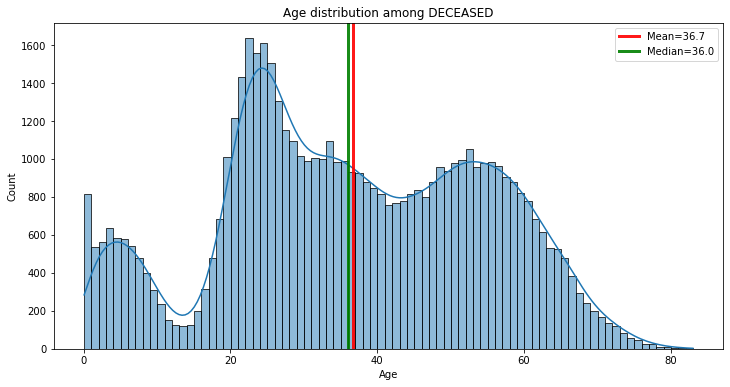

In [50]:
## your code
#Количество NaN среди поля Survived равно нулю.

figsize = (12,6)
plt.figure(figsize=figsize)
dataAge = data[data['Age'].notna()]
sns.histplot(data= dataAge, x='Age', kde=True, bins=int(dataAge['Age'].max()))
mean = round(dataAge['Age'].mean(), 1)
median = round(dataAge['Age'].median(),1)
plt.axvline(mean, color='red', lw=3, alpha=0.9, label=f'Mean={mean}')
plt.axvline(median, color='green', lw=3, alpha=0.9, label=f'Median={median}')
plt.title("Age distribution")
plt.legend()
plt.show()

plt.figure(figsize=figsize)
dataAge = data[(data['Age'].notna()) & (data['Survived']==1)]
sns.histplot(data= dataAge, x='Age', kde=True, bins=int(dataAge['Age'].max()))
mean = round(dataAge['Age'].mean(), 1)
median = round(dataAge['Age'].median(),1)
plt.axvline(mean, color='red', lw=3, alpha=0.9, label=f'Mean={mean}')
plt.axvline(median, color='green', lw=3, alpha=0.9, label=f'Median={median}')
plt.title("Age distribution among SURVIVORS")
plt.legend()
plt.show()

plt.figure(figsize=figsize)
dataAge = data[(data['Age'].notna()) & (data['Survived']==0)]
sns.histplot(data= dataAge, x='Age', kde=True, bins=int(dataAge['Age'].max()))
mean = round(dataAge['Age'].mean(), 1)
median = round(dataAge['Age'].median(),1)
plt.axvline(mean, color='red', lw=3, alpha=0.9, label=f'Mean={mean}')
plt.axvline(median, color='green', lw=3, alpha=0.9, label=f'Median={median}')
plt.title("Age distribution among DECEASED")
plt.legend()
plt.show()

##### <font color="red"> Мои мысли </font>
Среди всех пассажиров возраст распределён достаточно сбалансировано, о чём говорит небольшая разница между медианой и средним. 
$mean_{deceases} < mean_{all} < mean_{survived} $, что говорит о том, что шансов выжить было больше у более взрослых людей

Среди погибших медиана стала меньше среднего, что говорит о том, что шанс погибнуть был выше у более молодых людей, о чём также говорит и наличие "пика" в районе 25 лет.

Наибольшая разница между между медианой и средним среди выживших, что говорит о том, что среди выживших есть несколько выдающихся по размеру групп. 


**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

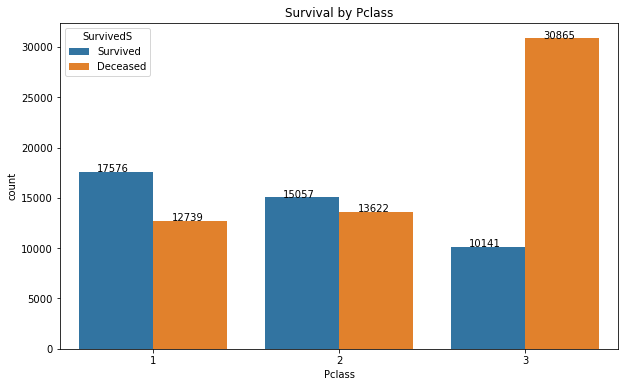

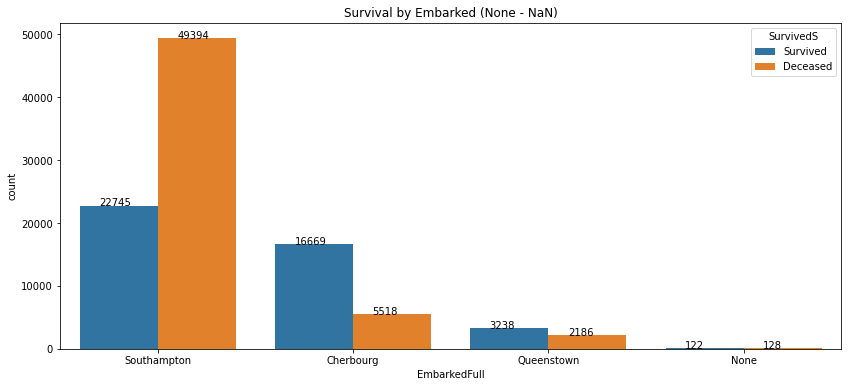

In [51]:
## your code
#Выживание для каждого возраста по каютам
#Survived string
data["SurvivedS"] = data["Survived"].map({0:"Deceased", 1:"Survived"})

#Пункт отправления меняем на N - неопределённый
data["EmbarkedS"] = data["Embarked"]
data.loc[data["EmbarkedS"].isna(), "EmbarkedS"] = "N"
#Подписываем названия городов
data['EmbarkedFull'] = data['EmbarkedS'].map({'C': 'Cherbourg', 'S': 'Southampton', 'Q': 'Queenstown', 'N': 'None'})

#Выживание по классу каюты
plt.figure(figsize=(10,6))
ax = sns.countplot(data = data, x='Pclass', hue="SurvivedS")

for p in ax.patches:
   ax.annotate(p.get_height(), (p.get_x()+0.1, p.get_height()))

plt.title('Survival by Pclass')
plt.show()

#Выживание по порту отправления (None - Не определён)
plt.figure(figsize=(14,6))
ax = sns.countplot(data = data, x='EmbarkedFull', hue="SurvivedS")

for p in ax.patches:
   ax.annotate(p.get_height(), (p.get_x()+0.1, p.get_height()))

plt.title('Survival by Embarked (None - NaN)')
plt.show()

data.drop(columns=['SurvivedS', 'EmbarkedFull', 'EmbarkedS'], inplace=True)

##### <font color="red"> Мои мысли </font>
* Наибольшее количество выживших (в абсолютном и относительном выражении) было среди пассажиров первого класса.
* Наименьшее количество выживших (в абсолютном и относительном выражении) было среди пассажиров третьего класса.
* Наибольшее количество выживших (в абсолютном выражении) было среди пассажиров из Southampton (22745)
* Однако, наибольшая вероятность погибнуть также была среди пассажиров из Southampton (49394/22745)
* Наибольшая вероятность выжить была у пассажиров из Cherbourg (16669/5518)

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [53]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [54]:
percent_missing = round(100* data.isnull().sum() / len(data),4)
print(percent_missing)

Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          3.292
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.134
Cabin       67.866
Embarked     0.250
dtype: float64


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

##### <font color="red"> Мои мысли </font>
* **Age** - логично было бы взять средний возраст, но тогда будет заметный выброс по распределению возраста. Следовательно, лучше взять просто рандомный возраст с распределением как у существующей части. А ещё лучше, сделать возрастные группы.
* **Ticket** - строковая величина, из которой можно пробовать получить некоторые дополнительные параметры. Нужно разложить на возможные features и заполнить их рандомными значениями с распределением как у известной части
* **Fare** - отсуствует 0.13%. Можно заполнить средними значениями для класса. Большой ошибки не должно принести
* **Cabin** - отсутствует 67% данных. Заполняя их можно сильно испортить данные. Рекомендовал бы удалить либо заполнить случайными значениями в пропорции равной известной части
* **Embarked** - отсуствует 0.25%. Можно заполнить случайными значениями в пропорции равной известной части

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [57]:
#Создание новых параметров, на основе имеющихся
def create_new_features(df):
    #Добавим параметр Deck(палуба) на основе первой буквы каюты
    df["Deck"] = df["Cabin"].str.slice(0,1)
    df["Deck"] = df["Deck"].map({"A":1, "B":2, "C":3, "D":4, "E":5, "F":6})

    #Создаём поле с возрастной группой
    df["AgeGroup"] = pd.cut(df["Age"], bins=[0.001, 10, 18, 40, 60, df["Age"].max()], include_lowest=True).apply(str)\
                        .map({'(0.0, 10.0]': '0-10','(10.0, 18.0]': '10-18',
                              '(18.0, 40.0]': '18-40','(40.0, 60.0]': '40-60','(60.0, 87.0]': '60-87'})
  #  df["AgeGroupD"] = df["AgeGroup"].map({'0-10': 1,'10-18': 2,'18-80': 3,'60-87': 4})
    return df

In [58]:
data = create_new_features(data)

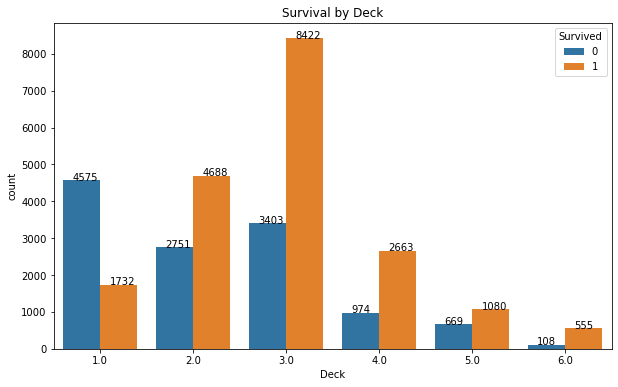

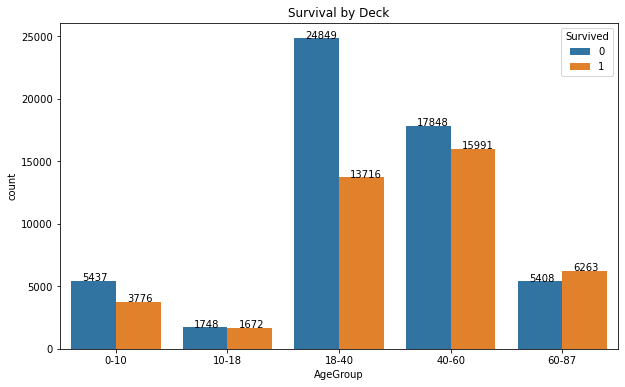

In [59]:
#Выживание по палубе
plt.figure(figsize=(10,6))
ax = sns.countplot(data = data, x='Deck', hue="Survived")

for p in ax.patches:
   ax.annotate(p.get_height(), (p.get_x()+0.1, p.get_height()))

plt.title('Survival by Deck')
plt.show()

#Выживание по группе возраста
plt.figure(figsize=(10,6))
ax = sns.countplot(data = data, x='AgeGroup', hue="Survived")

for p in ax.patches:
   ax.annotate(p.get_height(), (p.get_x()+0.1, p.get_height()))

plt.title('Survival by Deck')
plt.show()



In [60]:
def fill_na(df, feature, seed=4444):
    dist = df[df[feature].notna()].sort_values(by=[feature]).groupby(feature)[feature].count()
    na_count = df[df[feature].isna()].shape[0]
    np.random.seed(seed)
    df.loc[df[feature].isna(), feature] = np.random.choice(dist.index.values, 
                                                            na_count, 
                                                            p=dist.values/dist.sum())
    return df

def fill_na_by_survived(df, feature, seed=4444): #Не помогло )
    surv_list = df['Survived'].unique()
    for surv in surv_list:
        dist = df[(df[feature].notna()) & (df['Survived']==surv)].sort_values(by=[feature]).groupby(feature)[feature].count()
        na_count = df[(df[feature].isna()) & (df['Survived']==surv)].shape[0]
        np.random.seed(seed + pclass*10)
        df.loc[(df[feature].isna()) & (df['Survived']==surv), feature] =np.random.choice(dist.index.values, 
                                                                                         na_count, 
                                                                                         p=dist.values/dist.sum()) 
    return df

def fill_na2(df, feat1, feat2_class, seed=4444):
    classes = df[feat2_class].unique()
    for pclass in classes:
        dist = df[(df[feat1].notna()) & (df[feat2_class]==pclass)].sort_values(by=[feat1]).groupby(feat1)[feat1].count()
        na_count = df[(df[feat1].isna()) & (df[feat2_class]==pclass)].shape[0]
        np.random.seed(4444 + pclass*10)
        df.loc[(df[feat1].isna()) & (df[feat2_class]==pclass), feat1] = np.random.choice(dist.index.values, 
                                                                                         na_count, 
                                                                                         p=dist.values/dist.sum())  
    return df

def fill_na_full(df, seed):
    df = fill_na(df, 'Age', seed) 
    df = fill_na(df, 'AgeGroup', seed) 
    df = fill_na(df, 'Ticket', seed*2)
    df = fill_na(df, 'Embarked', seed*3)
    df = fill_na(df, 'Deck', seed*4)
    df = fill_na2(df, feat1 = 'Fare', feat2_class='Pclass', seed=seed * 5 )
    return df
    
def fill_na_full_by_survived(df, seed): #Не помогло
    df = fill_na_by_survived(df, 'Age', seed) 
    df = fill_na_by_survived(df, 'AgeGroup', seed)     
    df = fill_na_by_survived(df, 'Ticket', seed*2)
    df = fill_na_by_survived(df, 'Embarked', seed*3)
    df = fill_na_by_survived(df, 'Deck', seed*4)
    df = fill_na2(df, 'Fare', 'Pclass', seed*5)
    return df


In [61]:
print("Заполняем отсутствующие значения с учётом распределения выживаемости")
data = fill_na_full(data,  seed=6666)

Заполняем отсутствующие значения с учётом распределения выживаемости


In [62]:
def get_surv_rate(df, feature):
    surv_rate = data[data['Survived']==1].groupby(by=feature)[feature].count() \
                    / data[data['Survived']==0].groupby(by=feature)[feature].count()
    surv_rate = surv_rate/surv_rate.max()
    return pd.DataFrame(surv_rate).to_dict()[feature]

In [96]:
from sklearn import preprocessing
#Нормализация. Для этого заменим все "строковые значения" численными и нормализуем все параметры до нужных нам величин
def normalization(df):
    for feature in df.columns:
        if df[feature].unique().shape[0] < 10:
            df[feature] = pd.to_numeric(df[feature].map(get_surv_rate(df, feature)))
        else:
            df[feature] =(df[feature] / df[feature].max() + 0.1)/1.1 #Избавляемся от маленьких значений
            
    #df["Sex"] = df["Sex"].map(get_surv_rate(df, 'Sex'))
   # df["Sex"] = df["Sex"].map({'male': 1, 'female': 12}) 
    #df["Sex"] = df["Sex"].map(get_surv_rate(data, 'Sex')) 
    #df['Sex'] = df['Sex']/df['Sex'].max()
    #df['Embarked'] = df['Embarked'].map({'C': 3.01, 'S': 0.46, 'Q': 1.5, 'N': 0})
    #df['Embarked'] = df['Embarked']/df['Embarked'].max()
    #df['Pclass'] = df['Pclass'].map({1: 3*1.38, 2: 3*1.1, 3: 3*0.33}) 
    #df['Pclass'] = (df['Pclass']/df['Pclass'].max())
    #df['Deck'] = df['Deck'].map({1:17/45, 2: 47/27, 3: 84/34, 4: 27/10, 5:1080/669, 6:555/108})   
    #df['Deck'] = df['Deck']/df['Deck'].max()
    #df['Age'] = df['Age']/df['Age'].max()
    #df['SibSp'] = df['SibSp'].map({0:42/31, 1: 111/86, 2: 20/17, 3: 10/7, 4:73/44, 5:107/25, 6:})   
    #df['SibSp'] = df['SibSp']/df['SibSp'].max()
    #df['Parch'] = df['Parch']/df['Parch'].max()
    
    columns = df.columns
    index = df.index
    #return pd.DataFrame(data = preprocessing.normalize(df), columns=columns, index=index)
    return df


In [97]:
print('"Нормализуем" веса с учётом выживаемости')
norm_data = normalization(data.drop(columns=['Survived', 'Name', 'Ticket', 'Cabin', 'Age']))


"Нормализуем" веса с учётом выживаемости


##### Логистическая регрессия

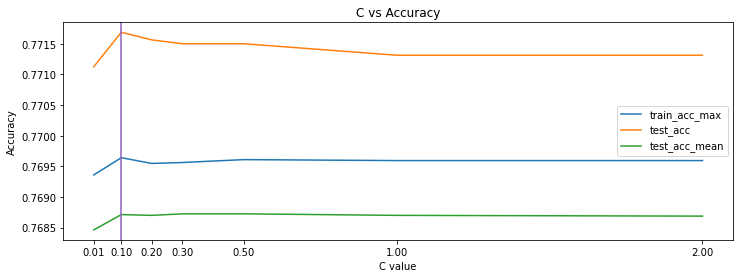

In [98]:
from sklearn.linear_model import LogisticRegression

X = norm_data
y = data["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

plt.figure(figsize=(12,4))
train_acc_arr_log=list()
test_acc_arr_log=list()
test_acc_arr_mean_log=list()
estimators_log = list()

c_list = [0.01, 0.1, 0.2, 0.3, 0.5, 1, 2]
for c in c_list:
    results = cross_validate(LogisticRegression(max_iter=300, C=c), 
                             X_train, y_train, cv=5,
                             return_estimator=True,
                             return_train_score=True,
                             scoring='accuracy')
    train_acc_arr_log.append(np.max(results['train_score']))
    test_acc_arr_log.append(np.max(results['test_score']))
    test_acc_arr_mean_log.append(np.mean(results['test_score']))
    estimators_log.append(results['estimator'][np.argmax(results['test_score'])])

plt.plot(c_list, train_acc_arr_log, label = f'train_acc_max')
plt.plot(c_list, test_acc_arr_log, label = f'test_acc')
plt.plot(c_list, test_acc_arr_mean_log, label = f'test_acc_mean')
plt.axvline(c_list[np.argmax(test_acc_arr_log)], color='C4', lw=2,  alpha=0.8)
plt.title('C vs Accuracy')
plt.xticks(c_list)
plt.xlabel("C value")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##### KNN

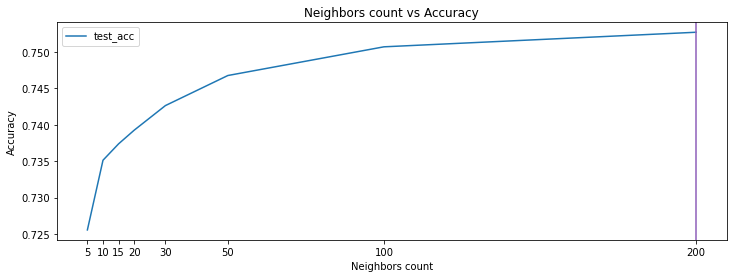

Wall time: 8min 15s


In [99]:
%%time
## X = norm_data.drop(columns="Survived")

X=normalization(data.drop(columns=['Survived', 'Name', 'Ticket', 'Cabin', 'Age']))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

plt.figure(figsize=(12,4))
train_acc_arr=list()
test_acc_arr=list()
estimators_knn = list()

n_neighbors_list = [5, 10, 15, 20, 30, 50, 100, 200 ]
for n_neighb in n_neighbors_list:
    results = cross_validate(KNeighborsClassifier(n_neighbors=n_neighb, weights='distance'), 
                             X_train, y_train, cv=5,
                             return_estimator=True,
                             return_train_score=True,
                             scoring='accuracy')
    train_acc_arr.append(np.max(results['train_score']))
    test_acc_arr.append(np.max(results['test_score']))
    estimators_knn.append(results['estimator'][np.argmax(results['test_score'])])

#plt.plot(n_neighbors_list, train_acc_arr, label = f'train_acc')
plt.plot(n_neighbors_list, test_acc_arr, label = f'test_acc')
plt.axvline(n_neighbors_list[np.argmax(test_acc_arr)], color='C4', lw=2,  alpha=0.8)
plt.title('Neighbors count vs Accuracy')
plt.xticks(n_neighbors_list)
plt.xlabel("Neighbors count")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


##### <font color="red"> Мои мысли </font>
* Как оказалось, с моими преобразованиями и с выбранным датасетом логистический регрессия работает лучше, чем KNN (при использовании метрики Accuracy)

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

#### Основной код и feature engineering сделан выше. Здесь только подбиваются результаты.
 **При этом используем среднее значение от двух моделей**

In [100]:
## your code
test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
test = create_new_features(test)
test = fill_na_full(test, 6666)
test = test.drop(columns=['Name', 'Ticket','Cabin', 'Age'])
test = normalization(test)

model_logistic = estimators_log[np.argmax(test_acc_arr_log)] 
model_knn = estimators_knn[np.argmax(test_acc_arr)] 


test_proba = (model_logistic.predict_proba(test) + model_knn.predict_proba(test))/2
#test_proba = model_logistic.predict_proba(test)
#test_proba = model_knn.predict_proba(test)
test_proba

array([[0.87328974, 0.12671026],
       [0.50240977, 0.49759023],
       [0.1559575 , 0.8440425 ],
       ...,
       [0.94292915, 0.05707085],
       [0.11817004, 0.88182996],
       [0.07457137, 0.92542863]])

In [ ]:
res = np.argmax(test_proba, axis=1)
res_df = pd.DataFrame({'PassengerId' : test.index.values, 'Survived' : res}).set_index('PassengerId')
res_df.to_csv("res.csv")

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

**Почему-то на kaggle не получилось поставить птичку "Use for final score"? Пишет, deadline прошёл. Поэтому так!**

![jupyter](https://i.ibb.co/cyZHWcR/2.png)